In [24]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from ipywidgets import interact
from scipy.special import gamma

eps = 10**(-4)
G = 6.67e-11
A_NFW = 4.625
f_b = 0.16 # baryon fraction 
sigma_T = 6.6525e-29  # thomson cross-section
m_e = 9.1094e-31
c = 2.9979e8
mu = 0.6
mu_e = 1.14  # mean electron molecular weight
k_B = 1.38e-23  # boltzmann constant in J/K

In [25]:
# calculating the hubble parameter

z = 1

hubble_factor = 1/(1+z)

H_0 = 2.27e-18

H = H_0 * np.sqrt(1e-3 * hubble_factor**(-4) + 0.3 * hubble_factor**(-3) + 0 * hubble_factor**(-2) + 0.7)

print(H)

# halo mass
M_halo = 1e15 * 2e30 #kg

# critical density
rho_cr = 3 * H**2 / (8 * np.pi * G)

Delta = 200

# setting r_halo to r_200
r_halo = (2*G*M_halo / (H**2 * Delta))**(1/3)

# circular velocity at r_halo
vc2_halo = G * M_halo / r_halo

print('The halo radius is', r_halo / 3.086e19, 'kpc')
print('The halo circular velocity is', np.sqrt(vc2_halo)/1e3, 'km/s')

# we use the an NFW profile to calculate the velocity ratio which remains constant, then use it to find v_phi^2
def vc2_NFW_template(x):
    return A_NFW * (np.log(1+x) / x - 1 / (1+x))

ratio_point = 10

halo_vc2_ratio = vc2_NFW_template(ratio_point)

vphi2 = vc2_halo / halo_vc2_ratio

print('The maximum circular velocity is', np.sqrt(vphi2)/1e3, 'km/s')

4.007048340112706e-18
The halo radius is 1413.9681718000284 kpc
The halo circular velocity is 1748.4778585507963 km/s
The maximum circular velocity is 2107.1014794419784 km/s


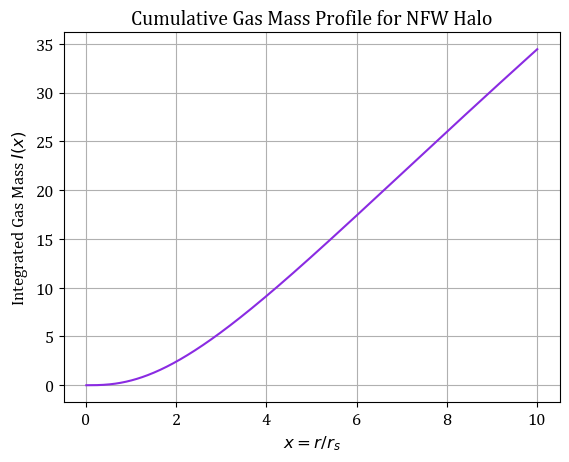

In [26]:
# Using the model described in the first notebook up to finding I(x)

x_values = np.linspace(0.01, 10, 500)

rmax = 2.16258

def alpha(x):
    return (3.4*x)/(rmax + x)

def integrandf_P(t):
    return alpha(t) / t

def f_P(x):        
    resultf_P, _ = integrate.quad(integrandf_P, 1+eps, x, limit=500)
    return np.exp(-resultf_P)

def v2_NFW(x):
    return A_NFW * vphi2 * (np.log(1+x) / x - 1 / (1+x))

def integrandI(t):
    return vphi2 * alpha(t) * f_P(t) * t**2 / (v2_NFW(t))

def I(x):        
    resultI, _ = integrate.quad(integrandI, eps, x, limit=50)
    return resultI

I_vec = np.vectorize(I)
y_I = I_vec(x_values)

cfont = {'fontname':'cambria'}
plt.rcParams['font.family'] = 'cambria' 
plt.rcParams['font.size'] = 12  
plt.plot(x_values, y_I, color='blueviolet')
plt.title('Cumulative Gas Mass Profile for NFW Halo', **cfont)
plt.xlabel('$x = r/r_{s}$',  **cfont)
plt.ylabel('Integrated Gas Mass $I(x)$',  **cfont)
plt.grid(True)

In [27]:
# mass of the CGM
M_CGM = f_b * M_halo

r_0 = r_halo / ratio_point

# pressure normalization
P_0 = M_CGM * vphi2 / (4*np.pi * r_0**3 * I(r_halo/r_0))

print('P_0:', P_0)

# density profile
def rho(r):
    return P_0 * alpha(r/r_0) * f_P(r/r_0) / v2_NFW(r/r_0)

# pressure profile
def P(r):
    return P_0 * f_P(r/r_0)

P_0: 3.951297027555313e-11


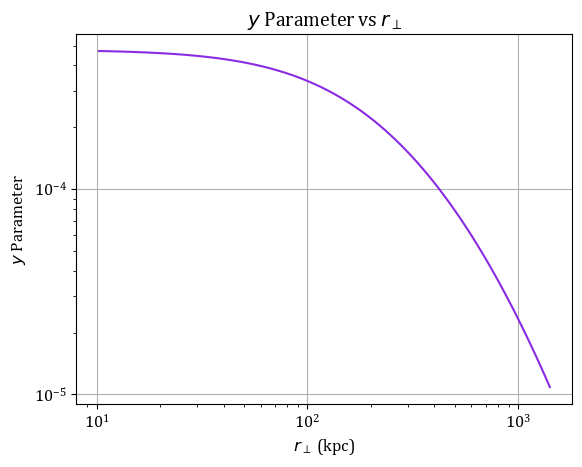

In [28]:
# We can now start calculating different model outputs.

# This is the integral along a line of sight that gives the Compton y parameter
def y_parameter(r_perp):
    def integrand(r_parallel):
        r = np.sqrt(r_perp**2 + r_parallel**2)
        return f_P(r/r_0)
    
    integral, _ = integrate.quad(integrand, 0, r_halo, limit=500)
    coeff = (2 * P_0 * mu * sigma_T) / (mu_e * m_e * c**2)
    return coeff * integral

r_perp_values = np.logspace(20.5, np.log10(r_halo), 100)
y_values = np.vectorize(y_parameter)(r_perp_values)
r_perp_values_kpc = r_perp_values / 3.086e19

cfont = {'fontname':'cambria'}
plt.rcParams['font.family'] = 'cambria' 
plt.rcParams['font.size'] = 12  
plt.plot(r_perp_values_kpc, y_values, color='blueviolet')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r_\\perp$ (kpc)')
plt.ylabel('$y$ Parameter')
plt.title('$y$ Parameter vs $r_\\perp$')
plt.grid()
plt.show()


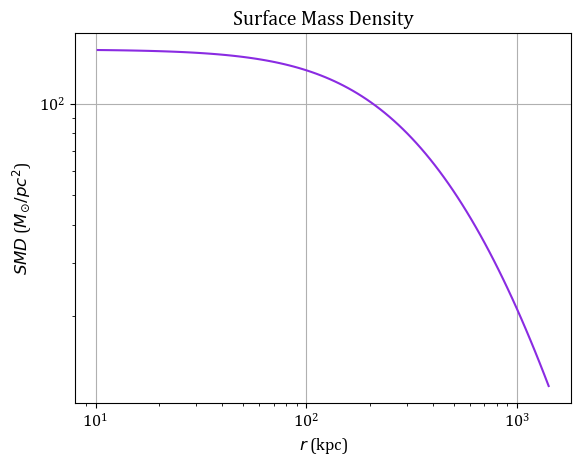

In [29]:
# integrating density along lines of sight with the same method gives the surface mass density
def SMD(r_perp):
    def integrand(r_parallel):
        r = np.sqrt(r_perp**2 + r_parallel**2)
        return rho(r) 

    result, _ = integrate.quad(integrand, 0, r_halo, limit=500)
    
    return 2 * result

SMD_1_values = np.vectorize(SMD)(r_perp_values)
SMD_1_values_Msunpc2 = SMD_1_values * 476.1698

cfont = {'fontname':'cambria'}
plt.rcParams['font.family'] = 'cambria' 
plt.rcParams['font.size'] = 12  
plt.plot(r_perp_values_kpc, SMD_1_values_Msunpc2, color='blueviolet')
plt.xlabel(r'$r$ (kpc)')
plt.ylabel(r'$SMD$ ($M_{\odot} / pc^2$)')
plt.title('Surface Mass Density')
plt.xscale('log')
plt.yscale('log')
plt.grid()